In [4]:
import pandas as pd
import gzip
import polars as pl


pl.Config.set_tbl_rows(1000)

polars.config.Config

In [11]:
exp_name = "100M_samples_expansion_50_zipf"
counts_path = f"../results/{exp_name}/PCFG/sentence_counts.gz"
counts = pl.read_csv(
    counts_path,
    separator="\t",
    has_header=False,
    new_columns=["sentence", "count"],
    n_threads=15,
)

In [ ]:
result = (
    counts.select(pl.col("count").value_counts(name="frequency"))
    .unnest("count")
    .sort("count", descending=False)
)

result

In [13]:
# 文の長さの分布を計算
counts_with_len = counts.with_columns(
    pl.col("sentence").str.split(" ").list.len().alias("len")
)

# 長さごとの頻度を集計
len_dist = (
    counts_with_len.group_by("len")
    .agg(pl.col("count").sum().alias("total_sentences"))
    .sort("len")
)

print("文の長さの分布:")
len_dist

文の長さの分布:


len,total_sentences
u32,i64
4,17311718
5,7024425
6,12005614
7,8319953
8,9233061
9,6135065
10,6378206
11,5046084
12,4915297


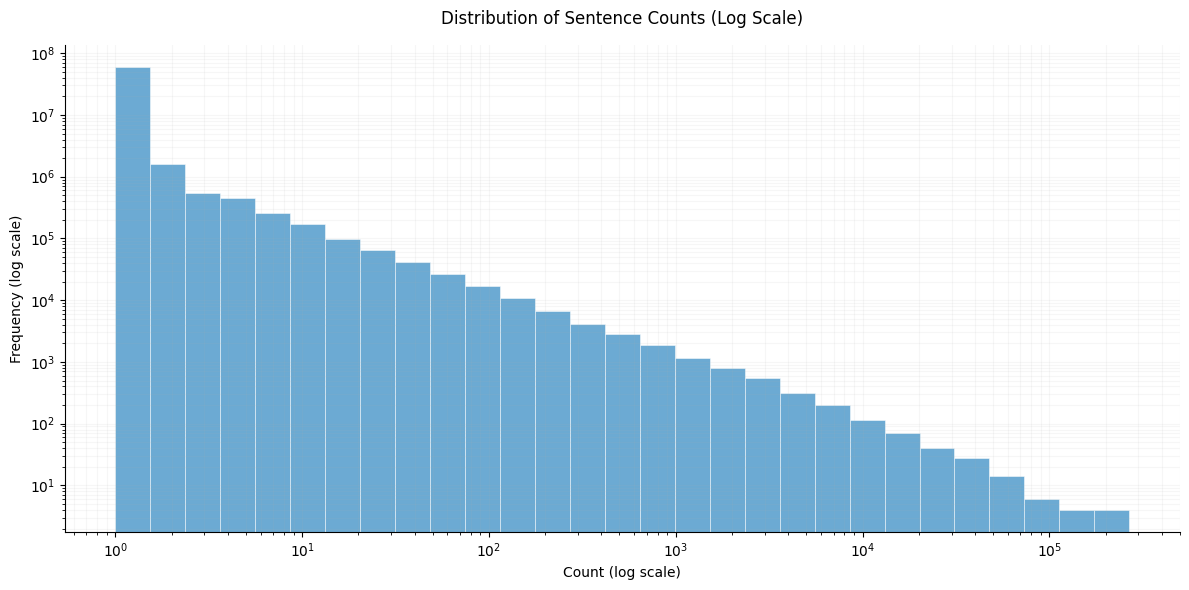

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# プロットのスタイル設定
plt.figure(figsize=(12, 6))

# ヒストグラムを作成（両対数スケール）
# binsを調整して、データの分布をより自然に表示
bins = np.logspace(
    np.log10(counts["count"].min()), np.log10(counts["count"].max()), num=30
)  # ビンの数を30に調整

plt.hist(
    counts["count"],
    bins=bins,
    log=True,
    alpha=0.7,  # 透明度を少し上げる
    color="#2E86C1",  # より落ち着いた青色
    edgecolor="white",  # 白い枠線
    linewidth=0.5,
)  # 枠線を細く
plt.xscale("log")

# グラフの設定
plt.title("Distribution of Sentence Counts (Log Scale)", fontsize=12, pad=15)
plt.xlabel("Count (log scale)", fontsize=10)
plt.ylabel("Frequency (log scale)", fontsize=10)
plt.grid(True, which="both", ls="-", alpha=0.1)  # グリッドを薄く

# 軸の設定を調整
plt.gca().spines["top"].set_visible(False)  # 上の枠線を消す
plt.gca().spines["right"].set_visible(False)  # 右の枠線を消す

# グラフを表示
plt.tight_layout()
plt.show()

## sanity check

In [16]:
sample_size = 100_000_000
exp_name = "100M_samples_expansion_30_zipf"
base_path = f"/cluster/home/tsomeya/projects/prefix_parsing/results/{exp_name}/PCFG"

# 全てのsplitファイルを読み込んでconcatする
dfs = []
for split_num in range(1, 16):  # 1から15まで
    file_path = f"{base_path}/sanity_check_sample_100000_split_{split_num}_of_15.csv"
    try:
        df = pd.read_csv(file_path)
        dfs.append(df)
    except FileNotFoundError:
        print(f"Warning: File not found: {file_path}")

# DataFrameを結合
data = pd.concat(dfs, ignore_index=True)

# 確率を計算
data["monte-carlo_prob"] = data["count"] / sample_size

In [17]:
# KL divergence
import numpy as np
from scipy.stats import entropy

# Uniform distribution baseline
uniform_prob = np.full(len(data), 1 / len(data))
kl_div_uniform = entropy(data["true_prob"], uniform_prob)

# Zipf distribution baseline
n = len(data)
zipf_prob = 1 / (np.arange(1, n + 1) * np.sum(1 / np.arange(1, n + 1)))
kl_div_zipf = entropy(data["true_prob"], zipf_prob)

# Exponential distribution baseline
exp_prob = np.exp(-np.arange(n))
exp_prob = exp_prob / np.sum(exp_prob)  # Normalize
kl_div_exp = entropy(data["true_prob"], exp_prob)

# Monte Carlo estimation
kl_div_monte_carlo = entropy(data["true_prob"], data["monte-carlo_prob"])

print(f"KL Divergence (Uniform baseline): {kl_div_uniform:.6f}")
print(f"KL Divergence (Zipf baseline): {kl_div_zipf:.6f}")
print(f"KL Divergence (Exponential baseline): {kl_div_exp:.6f}")
print(f"KL Divergence (Monte Carlo): {kl_div_monte_carlo:.6f}")

KL Divergence (Uniform baseline): 9.652154
KL Divergence (Zipf baseline): 11.891328
KL Divergence (Exponential baseline): inf
KL Divergence (Monte Carlo): 0.180994


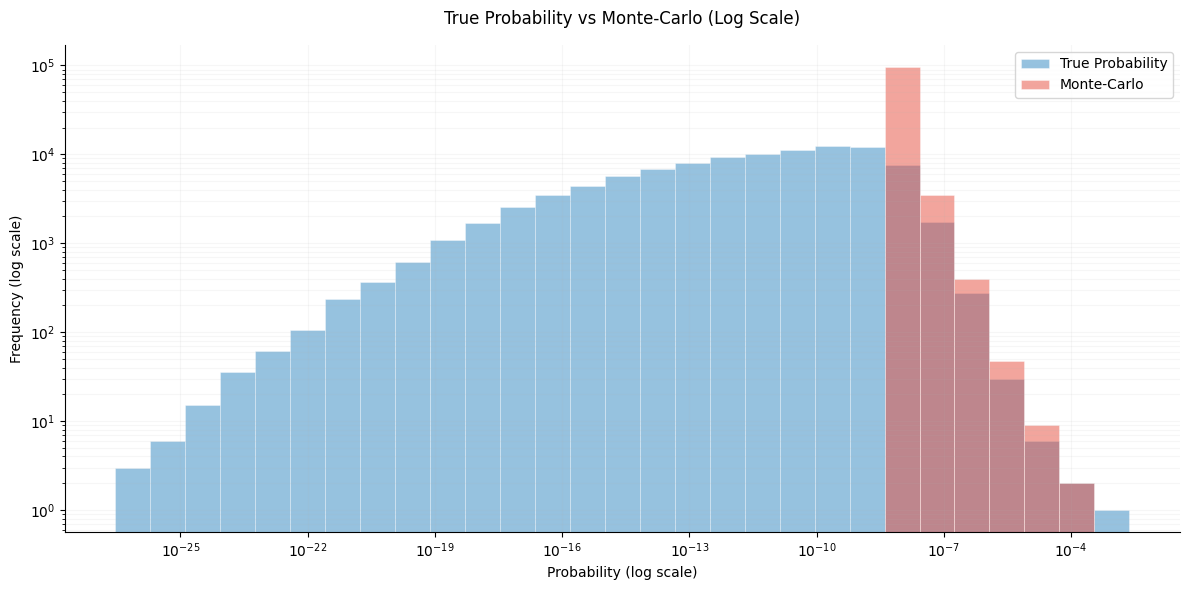

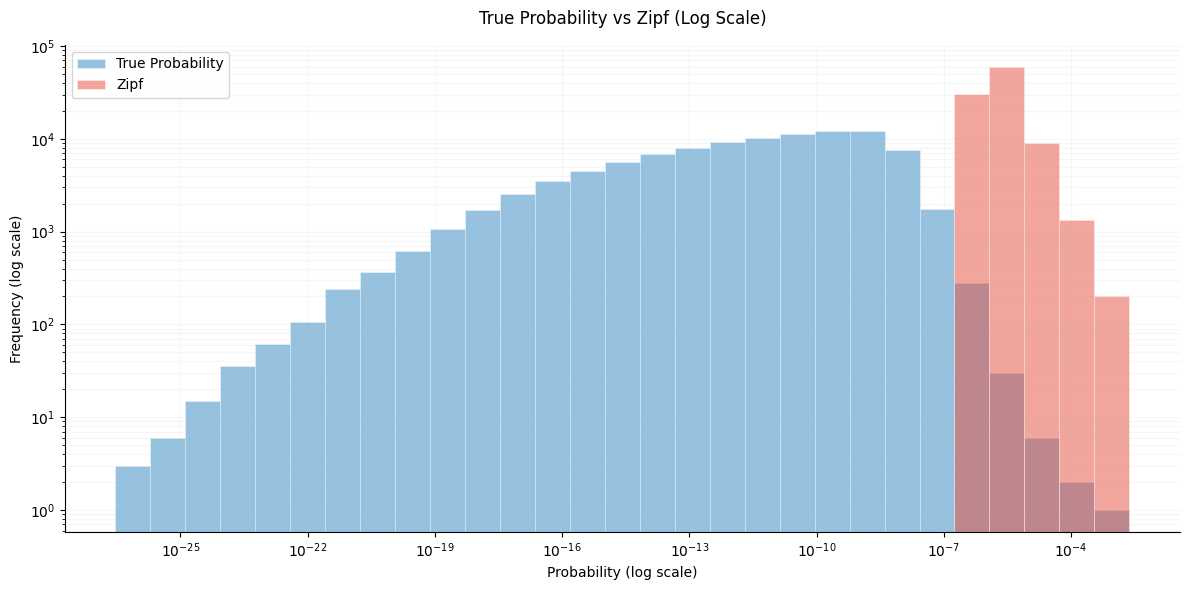

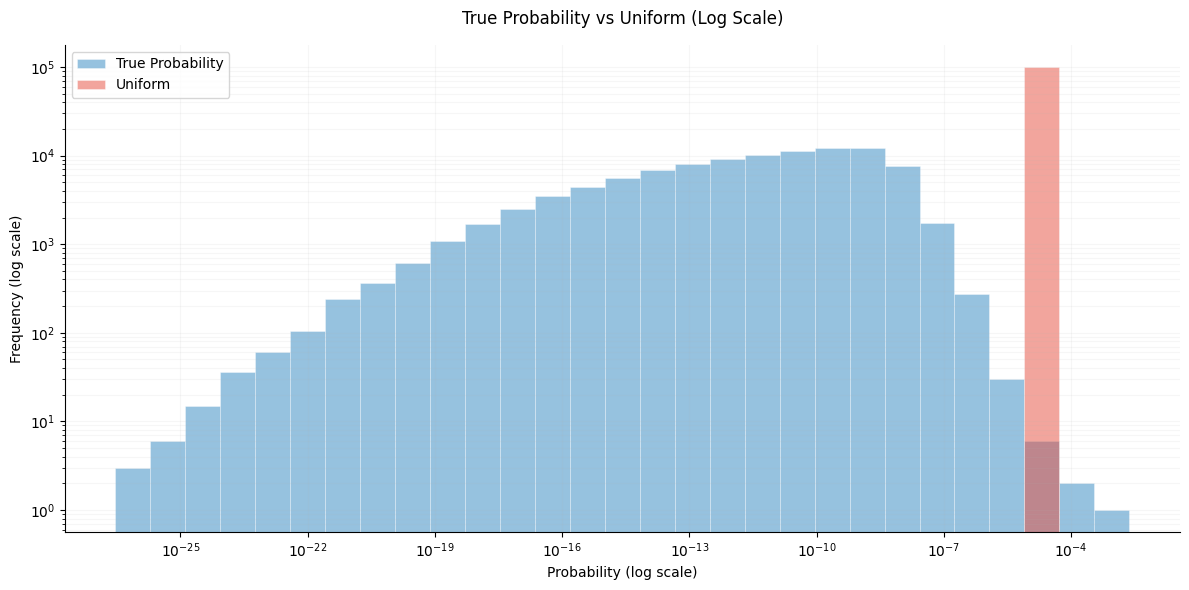

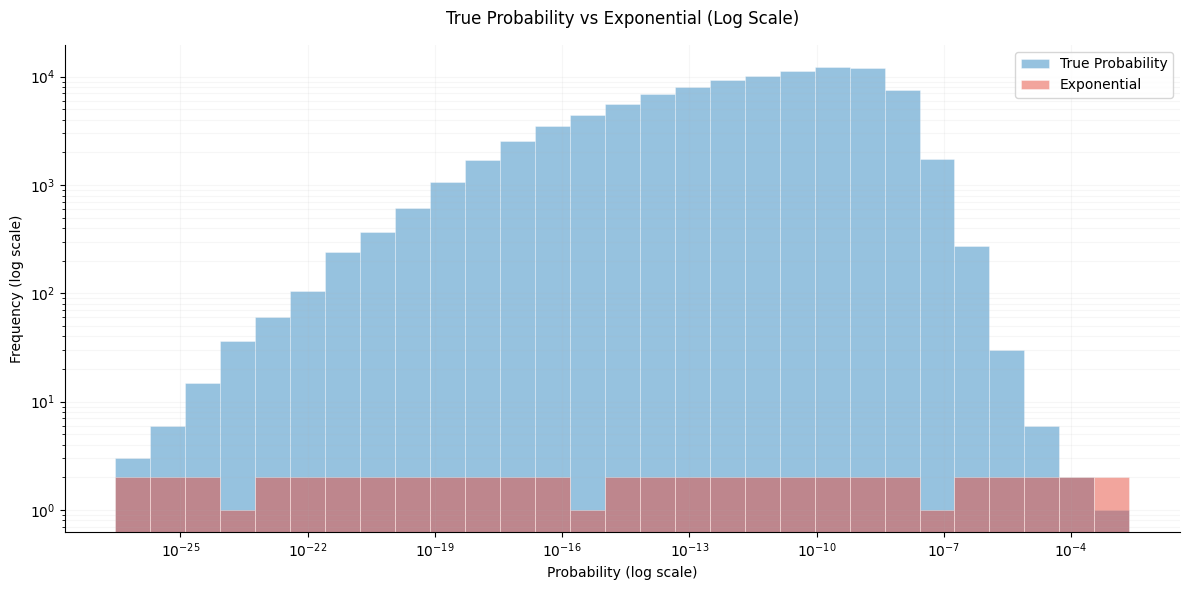

In [18]:
import matplotlib.pyplot as plt


def plot_probability_distributions(
    data, comparison_name, comparison_prob, figsize=(12, 6)
):
    """
    Plot true probability distribution with one comparison distribution

    Args:
        data (pd.DataFrame): DataFrame containing true_prob
        comparison_name (str): Name of the comparison distribution
        comparison_prob (np.array): Probability values of the comparison distribution
        figsize (tuple): Figure size
    """
    plt.figure(figsize=figsize)

    # Create bins for histogram
    bins = np.logspace(
        np.log10(data["true_prob"].min()), np.log10(data["true_prob"].max()), num=30
    )

    # Plot both distributions
    plt.hist(
        data["true_prob"],
        bins=bins,
        log=True,
        alpha=0.5,
        color="#2E86C1",
        edgecolor="white",
        linewidth=0.5,
        label="True Probability",
    )

    plt.hist(
        comparison_prob,
        bins=bins,
        log=True,
        alpha=0.5,
        color="#E74C3C",
        edgecolor="white",
        linewidth=0.5,
        label=comparison_name,
    )

    plt.xscale("log")
    plt.title(f"True Probability vs {comparison_name} (Log Scale)", fontsize=12, pad=15)
    plt.xlabel("Probability (log scale)", fontsize=10)
    plt.ylabel("Frequency (log scale)", fontsize=10)
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.1)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    plt.tight_layout()
    plt.show()


plot_probability_distributions(data, "Monte-Carlo", data["monte-carlo_prob"])


plot_probability_distributions(data, "Zipf", zipf_prob)


plot_probability_distributions(data, "Uniform", uniform_prob)


plot_probability_distributions(data, "Exponential", exp_prob)